# publication NLP

In [67]:
# Implemented by MZ; 08072019
# This will be put into a APP so that everybody can use this 
# Additional more information about authors citations topics ect will be provided
import re 
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Phrases
from gensim.parsing.preprocessing import preprocess_string,strip_tags, strip_punctuation, remove_stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
import nltk
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib.error import HTTPError
import time
from Bio import Entrez
from Bio import Medline
%matplotlib inline

In [36]:
# RETRIEVE DATA FROM PUBMED, entrez search engine with search parameters were used, at the moment only 10000 terms simultanouesly can be 
#retrieved, searchterms need to be assigned twice, to get the possible number of occurences.
def doc_function(search_term):
    """ this function should retrieve documents from the pubmed"""
    abstract_list = []
    title_list = []
    id_list = []
    journal_list = []
    
    pubdoc_dict = {"abstract_list" :[], "title_list": [], "id_list": [], "journal_list":[]}
    try:
        esearch_query = Entrez.esearch(db="pubmed", term= search_term ,retmax = 200000)
        esearch_result = Entrez.read(esearch_query)
        count = esearch_result['Count']
        esearch_query1 = Entrez.esearch(db="pubmed", term=search_term, retmax = count, retmode = "xlm")
        esearch_result1 = Entrez.read(esearch_query1)
        idlist = esearch_result1["IdList"]
        handle = Entrez.efetch(db="pubmed", id=idlist, rettype="medline", retmode="text", retmax = count)
        records = Medline.parse(handle)
        for record in records:
            try:
                if ("TI") in record.keys():
                    pubdoc_dict["id_list"].append(record["PMID"])
                    pubdoc_dict["abstract_list"].append(record["AB"])
                    pubdoc_dict["title_list"].append(record["TI"])
                    pubdoc_dict["journal_list"].append(record["JT"])
                else:
                    pass
            except Exception as e:
                # should be more specific for the error
                print(f"the following error occured: {e}")
                continue
        return pubdoc_dict
    except HTTPError:
        print("Currently no connection can be provided! Will try again")
        time.sleep(120)
        doc_function()

pubdoc = doc_function("gp130")

/home/physiologie/anaconda3/lib/python3.7/site-packages/Bio/Entrez/__init__.py:631: UserWarning: 
Email address is not specified.

To make use of NCBI's E-utilities, NCBI requires you to specify your
email address with each request.  As an example, if your email address
is A.N.Other@example.com, you can specify it as follows:
   from Bio import Entrez
   Entrez.email = 'A.N.Other@example.com'
In case of excessive usage of the E-utilities, NCBI will attempt to contact
a user at the email address provided before blocking access to the
E-utilities.
  UserWarning,


the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following error occured: 'AB'
the following 

In [9]:
#prepare preprocessing of input data--> get rid of punctuations, get rid of stopwords, get rid of numbers
stopword_list = ["among","although","especially","kg","km","mainly","ml","mm",
                 "disease","significantly","obtained","mutation","significant",
                 "quite","result","results","estimated","interesting","conducted",
                 "associated","performed","respectively","larger","genes","gene",
                 "mutations","related","expression","pattern","mutation","clc","identified",
                 "suprisingly","preferentially","subsequently","far","little","known","importantly",
                 "synonymous","skipping","father","mother","pedigree","novo","rescues","rescued","restored",
                "exhibits","induce"]

def preprocessing_list(liste,stopword_list):
    """ this preprocesses the abstracts removing stopwords
    removing digits and removing punctuations
    
    stopword_list <- list of additional stopwords associated with PuBMED articles"""
    ende = []
    for i in liste:
        CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation,remove_stopwords]
        a = preprocess_string(i, CUSTOM_FILTERS)
        no_integers = [x for x in a if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
        no_integers = [x for x in no_integers if x not in stopword_list]
        ende.append(no_integers)
    return ende


In [37]:
# Preprocess lists removign stopwords constructing bigrams and maybe trigrams 
# Construct the taggeddocument
processed_abstract_list = preprocessing_list(pubdoc["abstract_list"], stopword_list)
bigram = Phrases(processed_abstract_list,min_count = 5, threshold = 100)
trigram = Phrases(bigram[processed_abstract_list], threshold = 100)
documents = [TaggedDocument(doc, [i]) for i, doc in zip(pubdoc["id_list"],bigram[processed_abstract_list])]

In [38]:
# Train the Doc2Vec Model 
# Here different parameters and different model can be used out of bag or skip-grams
model = gensim.models.Doc2Vec(
        documents,
        vec_size=30,
        window = 15,
        min_count=4,
        epochs = 30,
        workers = 8,
        dm=0, 
        dbow_words=1)

model.train(documents,total_examples=model.corpus_count,epochs=model.epochs)

In [39]:
# Gives the most frequent words
model.wv.index2word[:10]

['il',
 'gp130',
 'cells',
 'receptor',
 'cell',
 'signaling',
 'stat3',
 '6r',
 'lif',
 'cytokine']

In [40]:
model.most_similar(positive = ["gp130"], topn = 10)

/home/physiologie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('receptor', 0.8434262275695801),
 ('signal_transducing', 0.7527254819869995),
 ('il', 0.7328349351882935),
 ('subunit', 0.7318161725997925),
 ('complex', 0.6658519506454468),
 ('signal_transducer', 0.6657088994979858),
 ('binding', 0.6591383814811707),
 ('signaling', 0.646379828453064),
 ('ligand', 0.6363662481307983),
 ('receptors', 0.6350620985031128)]

In [43]:
# retrieve the doctags and perform a TSNE reduction using the doctags
# Dimensional Reduction is used to visualize putative topics of the search key
# Here tSNE should be replaced by UMAP --> this will give better latent space representation 
# AS well as increased computation speed
doc_tags = list(model.docvecs.doctags.keys())
X = model[doc_tags]
tsne = TSNE(perplexity=25, n_components=2, init='pca', n_iter=8000)
X_tsne = tsne.fit_transform(X)
df_dx = pd.DataFrame(X_tsne, index=doc_tags, columns=['tSNE1', 'tSNE2'])

No handles with labels found to put in legend.


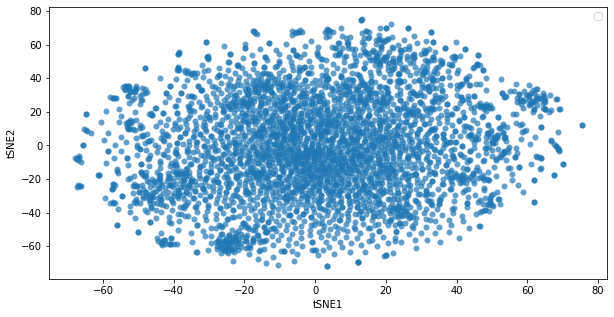

In [44]:
# Draw the tSNE Plot to detect the clusters
fig,ax = plt.subplots(figsize= (10,5))
sns.despine()
sns.scatterplot(x = "tSNE1", y= "tSNE2", data = df_dx, linewidth = 0, alpha = 0.7, legend = "full")
plt.legend()


In [45]:
#determine the number of cluster in our dataset using the elbow model and the distortions
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_tsne)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

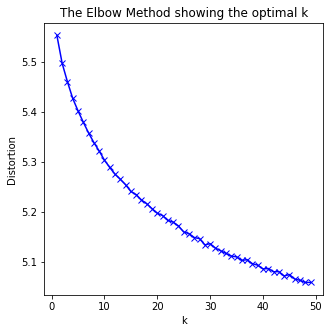

In [46]:
# Draw the distortion of the K-Means for the gp130 analysis
fig,ax = plt.subplots(figsize = (5,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
kmeanModel_end = KMeans(n_clusters=29).fit(X)
df_dx["labels"] = kmeanModel_end.labels_
df_dx["labels"] = df_dx["labels"].astype(int)

/home/physiologie/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


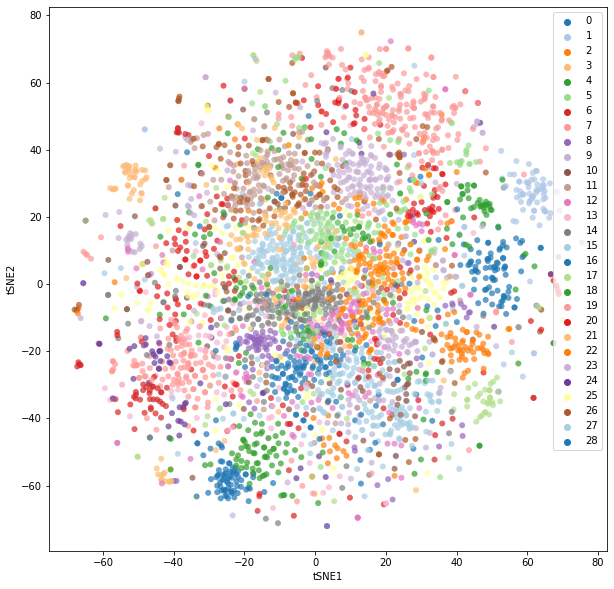

In [47]:
# Plot the data and the retrieved clusters
# We could try to improve perplexity here
cmap = sns.color_palette("tab20",15) + sns.color_palette("Paired",14)
fig,ax = plt.subplots(figsize= (10,10))
sns.scatterplot(df_dx["tSNE1"],df_dx["tSNE2"], hue = df_dx["labels"].tolist(), linewidth = 0, alpha = 0.7,palette = cmap , legend = "full")
plt.legend()

In [48]:
# construct a new dataframe with the texts and the clusters
# This can be used for topic construction
df_topics = pd.DataFrame()
df_topics["text"] = trigram[bigram[processed_abstract_list]]
df_topics["cluster"] = kmeanModel_end.labels_ 

In [56]:
pyLDAvis.enable_notebook()
id2word = corpora.Dictionary(df_topics["text"].values)
corpus = [id2word.doc2bow(text) for text in df_topics["text"].values]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20,
                                            alpha='auto',
                                            eta='auto',
                                            iterations=400,
                                            passes = 20,
                                            eval_every=1)


pprint(lda_model.print_topics())

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
p


[(0,
  '0.056*"stat3" + 0.030*"activation" + 0.029*"gp130" + 0.023*"signaling" + '
  '0.015*"il" + 0.014*"pathway" + 0.013*"induced" + 0.011*"phosphorylation" + '
  '0.009*"stat" + 0.009*"kinase"'),
 (1,
  '0.032*"gc" + 0.032*"epo" + 0.014*"pomc" + 0.008*"nt" + '
  '0.007*"breast_carcinoma" + 0.007*"gal" + 0.006*"ebi3" + 0.006*"hescs" + '
  '0.006*"epor" + 0.006*"her2"'),
 (2,
  '0.035*"astrocytes" + 0.031*"pituitary" + 0.022*"microglia" + 0.020*"ms" + '
  '0.019*"sympathetic_neurons" + 0.018*"th" + 0.017*"hormone" + 0.016*"lps" + '
  '0.013*"brain" + 0.012*"gfap"'),
 (3,
  '0.029*"g_csf" + 0.028*"cd34" + 0.022*"r" + 0.017*"progenitors" + '
  '0.017*"rankl" + 0.012*"presence" + 0.012*"mr" + 0.012*"factor" + '
  '0.010*"osteoclast_formation" + 0.009*"m_csf"'),
 (4,
  '0.047*"il" + 0.047*"sil" + 0.045*"patients" + 0.044*"6r" + 0.042*"sgp130" + '
  '0.040*"levels" + 0.031*"soluble" + 0.026*"serum" + 0.018*"p" + '
  '0.015*"interleukin"'),
 (5,
  '0.041*"ct" + 0.023*"cardiac" + 0.017*"hear

/home/physiologie/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.202863 -0.007371       1        1  19.779131
0     -0.206890 -0.083737       2        1  14.002274
16    -0.162394 -0.084587       3        1  13.684141
11    -0.203488 -0.126377       4        1  12.725432
14    -0.184835  0.082135       5        1   9.290647
19    -0.074624  0.222213       6        1   6.180648
7     -0.179508 -0.099416       7        1   5.404510
4     -0.086049  0.277939       8        1   3.600689
5     -0.042950  0.027292       9        1   2.731187
6     -0.013103  0.021919      10        1   2.562878
12    -0.011614  0.075231      11        1   2.342909
15     0.007145 -0.158460      12        1   1.718555
13     0.042945 -0.060469      13        1   1.580867
8      0.150853 -0.047141      14        1   0.980307
3      0.118165 -0.011691      15        1   0.968208
17     0.197768  0.017764      16        1   0.620981
18     0.182683 -0.013839      17        1   0.553351
2      0.218976 -0.019590      18        1   0.462727
1      0.236120 -0.002388      19        1   0.435744
10     0.213665 -0.009426      20        1   0.374820, topic_info=     Category          Freq        Term         Total  loglift  logprob
54    Default  17758.000000          il  17758.000000  30.0000  30.0000
451   Default   2555.000000         lif   2555.000000  29.0000  29.0000
282   Default   3533.000000       stat3   3533.000000  28.0000  28.0000
479   Default   3068.000000          6r   3068.000000  27.0000  27.0000
207   Default   7176.000000       cells   7176.000000  26.0000  26.0000
...       ...           ...         ...           ...      ...      ...
521   Topic20      7.218110    observed    678.903015   1.0426  -5.4355
5885  Topic20      5.784176     somatic     43.495396   3.5690  -5.6569
1279  Topic20      5.661014  mechanical     41.305573   3.5991  -5.6784
723   Topic20      6.238406           h    540.602295   1.1245  -5.5813
1006  Topic20      5.546924    transfer     43.235752   3.5331  -5.6988

[1295 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
478        5  0.973730  1beta
478        8  0.022873  1beta
4859      16  0.794856   5q11
479        1  0.734251     6r
479        5  0.033242     6r
...      ...       ...    ...
13191      1  0.055877   yxxq
13191     13  0.894026   yxxq
14207     20  0.903048   zfat
14814     10  0.977516   zinc
15739     15  0.930779  zones

[3652 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 17, 12, 15, 20, 8, 5, 6, 7, 13, 16, 14, 9, 4, 18, 19, 3, 2, 11])

In [65]:
# get the most similar words to searched keys
# retrieve the embeddings and the finally build a t-sne on the embedding to visualize the most 
# similar words
keys = ["il6", "il27","epo", "om", "bone", "bdnf"]
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    try:
        for similar_word, _ in model.most_similar(word, topn=20):
            words.append(similar_word)
            embeddings.append(model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    except:
        pass
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=5000)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/home/physiologie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/physiologie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/physiologie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/physiologie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead)

/home/physiologie/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/physiologie/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/physiologie/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/physiologie/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/physiologie/anaconda3/lib/pyth

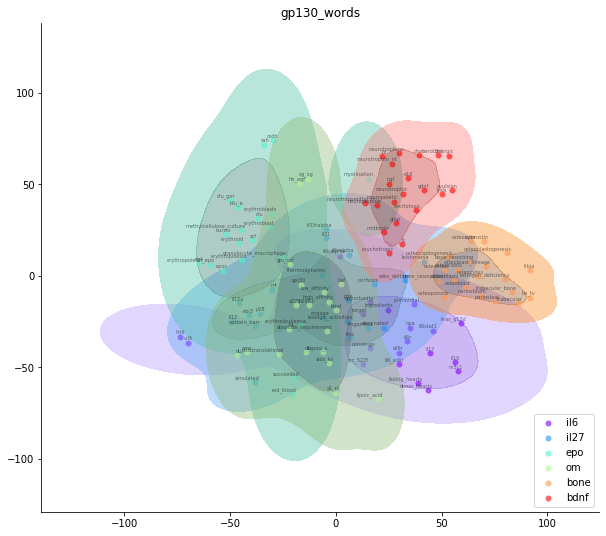

In [68]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    fig,ax = plt.subplots(figsize=(10, 10))
    sns.despine()
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        c = color 
        sns.kdeplot(x = x,y = y,color=c, shade = True,shade_lowest = False,n_levels=3,alpha = 0.4)
        sns.scatterplot(x=x,y=y, color=c, alpha=0.6, label=label, linewidth = 0)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=500, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('gp130_words', keys, embeddings_en_2d, word_clusters, 0.8)